# Analysis completed by Stephen Stark
# Jumpman23 - Exploratory Data Analysis

Jumpman23 is an on-demand delivery platform connecting “Jumpmen” and customers  purchasing a variety of goods. Jumpman23 will send Jumpmen to merchants to purchase and  pickup any items requested by the customer. Whenever possible, Jumpman23 will order the  requested items ahead to save the Jumpmen time. Each time a Jumpman23 delivery is  completed, a record is saved to the Jumpman23 database that contains information about that  delivery. Jumpman23 is growing fast and has just launched in its newest market -- New York City.

# Objective
The objective of this notebook is to answer the questions:
- How are things going in New York?
- Are there data integrity issues? 
    - If so, where are they and how do they impact the analysis?


I will use the dataset provided by Postmates. Demographic zip code data is from https://data.ny.gov/

# Summary
1. [Understand the data](#understand)\
    1.1 [N/A's?](#na)\
2. 
3.
4. 
5.
6. [Scratch](#scratch)

### Understanding the Delivery Process

A customer orders something from a business such as a restaurant or grocery store. Jumpman23 connects that customer with a Jumpman who will then travel to go pickup the item. The Jumpman picks up the item to bring back to the customer. The Jumpman travels by foot, bike, car, scooter, or other method to deliver the item to the customer. Once the item is delivered, a record is created with the following journey attribute information. 

### Understanding Delivery Attributes

- **Job_ID:**  a unique identifier of a delivery
- **Customer_id:** a unique identifier for the Jumpman23 customer
- **Jumpman_id:**  a unique identifier for the Jumpman who completed the delivery
- **vehicle_type:** The method of transport the Jumpman used to complete the delivery
- **pickup_place:** The name of the Pickup location
- **place_category:** A categorization of the Pickup location
- **Item_name:** the name of the item requested
- **Item_quantity:** how many of that item was requested
- **Item_category_name:** categorization provided by the merchant, think “appetizers”, “soups” etc
- **How_long_it_took_to_order:** how long it took to place the order [interval]
- **pickup_lat:** the coordinates of the pickup location
- **pickup_lon:** the coordinates of the pickup location
- **dropoff_lat:** the coordinations of the dropoff location
- **dropoff_lon:** the coordinations of the dropoff location
- **when_the_delivery_started:** localized timestamp representing when the delivery began
- **when_the_Jumpman_arrived_at_pickup:** localized timestamp representing when the Jumpman arrived at the pickup location
- **when_the_Jumpman_left_pickup:** localized timestamp representing when the Jumpman left the pickup location
- **when_the_Jumpman_arrived_at_dropoff :** localized timestamp representing when the Jumpman reached the customer

## Import Neccesary Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from collections import Counter
import haversine as hs
import os as os
from datetime import datetime, timedelta
import re
import missingno as msno
import geopy
from uszipcode import SearchEngine
import time

%matplotlib inline

In [2]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.listdir()

['.DS_Store',
 'Stephen_Stark_Analysis.pptx',
 'README.md',
 'img',
 '~$Stephen_Stark_Analysis.pptx',
 '.ipynb_checkpoints',
 'Stephen_Stark_Jumpman23Analysis.ipynb',
 '.git']

In [4]:
df = pd.read_csv('../Jumpman23/analyze_me.csv')

<a id='understand'></a>
## Understand the data

In order to answer the question of 'how are things going in NYC', we need to first spot check the data. We know there are potential data integrity issues. Lets look column by column to determine what sort of analysis we can do.

In [5]:
print(df.shape)
print(df.info())

(5983, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 18 columns):
delivery_id                            5983 non-null int64
customer_id                            5983 non-null int64
jumpman_id                             5983 non-null int64
vehicle_type                           5983 non-null object
pickup_place                           5983 non-null object
place_category                         5100 non-null object
item_name                              4753 non-null object
item_quantity                          4753 non-null float64
item_category_name                     4753 non-null object
how_long_it_took_to_order              3038 non-null object
pickup_lat                             5983 non-null float64
pickup_lon                             5983 non-null float64
dropoff_lat                            5983 non-null float64
dropoff_lon                            5983 non-null float64
when_the_delivery_started              5

In [6]:
df.iloc[2]

delivery_id                                               1476547
customer_id                                                 83095
jumpman_id                                                 132725
vehicle_type                                              bicycle
pickup_place                                           Bareburger
place_category                                             Burger
item_name                                              Bare Sodas
item_quantity                                                   1
item_category_name                                         Drinks
how_long_it_took_to_order                         00:06:44.541717
pickup_lat                                                40.7285
pickup_lon                                               -73.9984
dropoff_lat                                               40.7286
dropoff_lon                                              -73.9951
when_the_delivery_started              2014-10-28 21:39:52.654394
when_the_J

In [7]:
#Count of N/A or Null values in each column
df.isna().sum()

delivery_id                               0
customer_id                               0
jumpman_id                                0
vehicle_type                              0
pickup_place                              0
place_category                          883
item_name                              1230
item_quantity                          1230
item_category_name                     1230
how_long_it_took_to_order              2945
pickup_lat                                0
pickup_lon                                0
dropoff_lat                               0
dropoff_lon                               0
when_the_delivery_started                 0
when_the_Jumpman_arrived_at_pickup      550
when_the_Jumpman_left_pickup            550
when_the_Jumpman_arrived_at_dropoff       0
dtype: int64

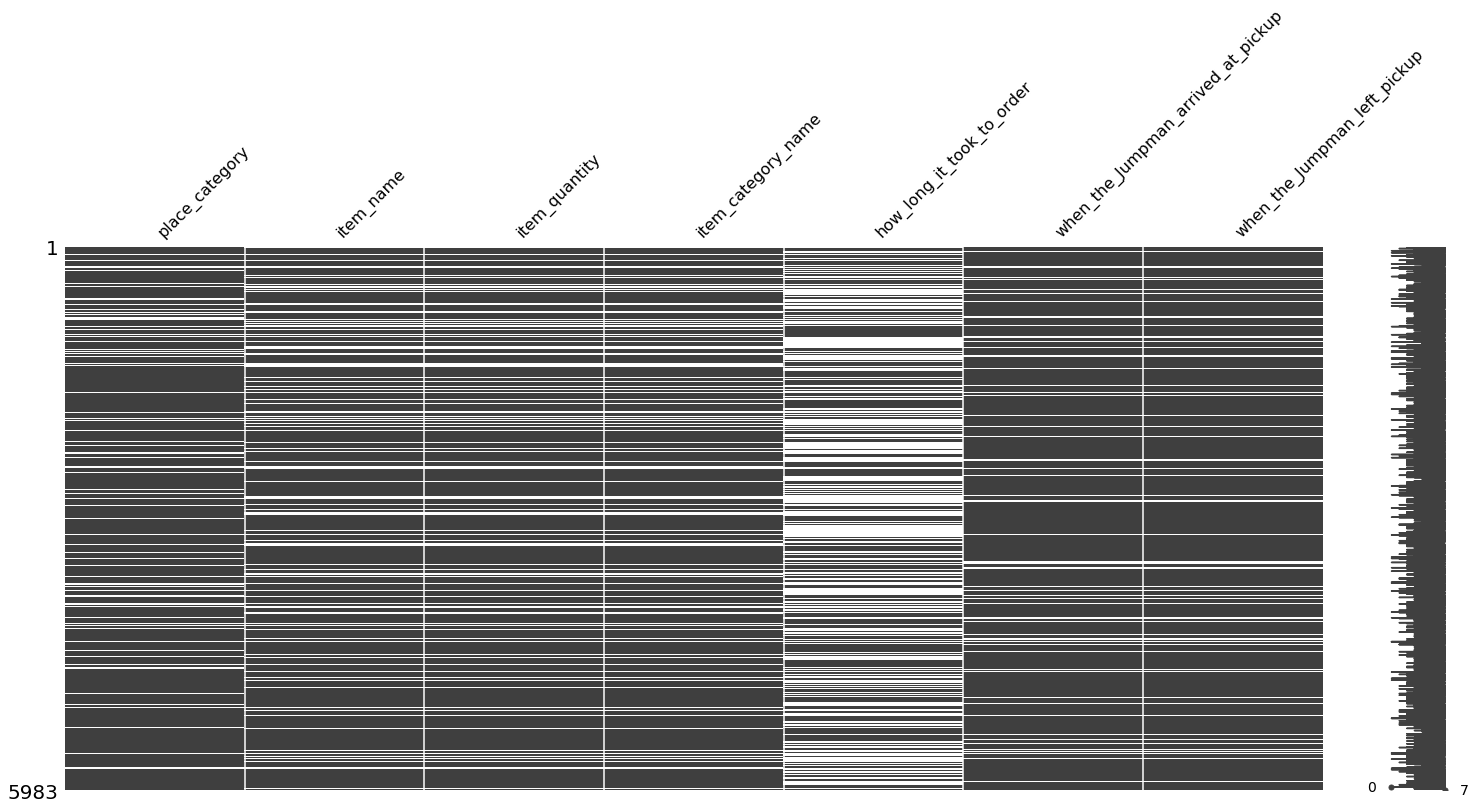

In [8]:
#visualization of missing data
missing_data_cols = ['place_category',
                     'item_name',
                     'item_quantity',
                     'item_category_name',
                     'how_long_it_took_to_order',
                     'when_the_Jumpman_arrived_at_pickup',
                     'when_the_Jumpman_left_pickup']

msno.matrix(df[missing_data_cols])
plt.show()

### 'delivery_id','customer_id','jumpman_id'

In [9]:
print('Count of records:', len(df))
print('---')
print('Count of unique elements in each id column:')

id_cols = ['delivery_id','customer_id','jumpman_id']
for i in id_cols:
    print(i,':', df[i].nunique())

Count of records: 5983
---
Count of unique elements in each id column:
delivery_id : 5214
customer_id : 3192
jumpman_id : 578


It is important to note the total number of records 5983 is greater than the unique elements for each id. I would expect customer_id and jumpman_id to be used mutliple times. However, I want to look into why the same delivery_id has been used multiple times.

In [10]:
df[df['delivery_id'].duplicated()].head(3)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
82,1314550,348787,119813,bicycle,Otto Enoteca Pizzeria,Italian,Prosciutto Arugula,1.0,Pizzas,00:22:42.942105,40.732064,-73.996155,40.767582,-73.983704,2014-10-07 18:40:38.769589,2014-10-07 18:49:49.978276,2014-10-07 19:27:58.470009,2014-10-07 19:55:56.804909
207,1332526,48677,152676,bicycle,Shake Shack,Burger,Smoke Shack,1.0,Burgers,NaN,40.715279,-74.014860,40.724520,-73.993420,2014-10-10 18:41:05.90546,2014-10-10 19:04:31.649579,2014-10-10 19:46:22.211936,2014-10-10 20:15:31.476676
244,1319971,94027,119255,walker,Trader Joe's,Grocery Store,Organic Autumn Wheat,1.0,Breakfast & Cereal,NaN,40.741740,-73.993650,40.736971,-73.985844,2014-10-08 19:33:52.549234,2014-10-08 19:45:18.293971,2014-10-08 20:38:07.37508,2014-10-08 20:49:29.420191


Based on the query below, it looks like multiple items from the same order are broken out on different records. I would expect all the other attributes to be the same for all cases. One way I could handle this is to merge the items into a list for each record. For the purposes of this analysis, I'll drop the duplicate records as I don't see a meaningful reason for including them in the analysis.

In [11]:
#sample duplicate row
df[df['delivery_id']==1272701]

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
1008,1272701,81085,112646,bicycle,Mighty Quinn's BBQ,BBQ,Brisket,1.0,Meats,NaN,40.727519,-73.988671,40.723962,-73.993393,2014-10-01 12:12:24.393054,2014-10-01 12:17:22.929789,2014-10-01 12:27:42.369732,2014-10-01 12:34:27.142996
5080,1272701,81085,112646,bicycle,Mighty Quinn's BBQ,BBQ,Housemade Iced Tea,1.0,Beverages,NaN,40.727519,-73.988671,40.723962,-73.993393,2014-10-01 12:12:24.393054,2014-10-01 12:17:22.929789,2014-10-01 12:27:42.369732,2014-10-01 12:34:27.142996


In [12]:
#duplicate row dataset
df[df['delivery_id'].duplicated()].sort_values(by='delivery_id')

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
5080,1272701,81085,112646,bicycle,Mighty Quinn's BBQ,BBQ,Housemade Iced Tea,1.0,Beverages,NaN,40.727519,-73.988671,40.723962,-73.993393,2014-10-01 12:12:24.393054,2014-10-01 12:17:22.929789,2014-10-01 12:27:42.369732,2014-10-01 12:34:27.142996
2299,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Moroccan Cigars (5 pc),1.0,Appetizers,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
2986,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Watermelon,1.0,Desserts,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
5386,1274328,255435,23359,bicycle,Lure Fishbar,Seafood,King Salmon,3.0,Sushi & Sashimi,00:11:23.081868,40.724635,-73.998402,40.743568,-73.972405,2014-10-01 17:47:16.707187,2014-10-01 17:44:49.255589,2014-10-01 18:21:08.892224,2014-10-01 18:41:16.203243
4578,1274372,82041,133293,bicycle,Parm,Italian,Chicken Parm,1.0,Sandwiches,00:02:31.470754,40.723020,-73.995854,40.720479,-74.001549,2014-10-01 17:57:34.871703,2014-10-01 17:57:34.041223,2014-10-01 18:09:53.957556,2014-10-01 18:20:05.578047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,1490188,166368,174143,motorcycle,Prosperity Dumpling,Chinese,Chives and Pork Dumplings in Soup,1.0,Dumplings,NaN,40.716001,-73.993210,40.775973,-73.947845,2014-10-30 21:00:30.703848,2014-10-30 21:08:00.931773,2014-10-30 21:44:21.145721,2014-10-30 22:07:09.83358
4119,1490188,166368,174143,motorcycle,Prosperity Dumpling,Chinese,Vegetable and Pork Dumplings in Soup,1.0,Dumplings,NaN,40.716001,-73.993210,40.775973,-73.947845,2014-10-30 21:00:30.703848,2014-10-30 21:08:00.931773,2014-10-30 21:44:21.145721,2014-10-30 22:07:09.83358
4983,1490744,52256,38597,bicycle,Han Dynasty,Chinese,Dan Dan Noodle,1.0,Noodles,00:09:51.159698,40.732213,-73.988072,40.732288,-73.987752,2014-10-30 21:44:05.205404,2014-10-30 21:51:58.394867,2014-10-30 22:06:52.148926,2014-10-30 22:08:06.563304
4074,1490744,52256,38597,bicycle,Han Dynasty,Chinese,Bok Choy with Black Mushrooms,1.0,Vegetables,00:09:51.159698,40.732213,-73.988072,40.732288,-73.987752,2014-10-30 21:44:05.205404,2014-10-30 21:51:58.394867,2014-10-30 22:06:52.148926,2014-10-30 22:08:06.563304


In [13]:
#drop duplicate rows based on delivery_id column
df = df.drop_duplicates(subset=['delivery_id'])

### 'vehicle_type','pickup_place','place_category','item_name','item_category_name'

The integrity of the following columns can be assessed by simply looking at the counts of the unique values in each set, as well as the size of the set itself.

In [14]:
select_cols = ['vehicle_type',
               'pickup_place',
               'place_category',
               'item_name',
               'item_category_name']

for col in select_cols:
    print(pd.DataFrame(df[col].value_counts()))

            vehicle_type
bicycle             3740
car                 1050
walker               234
van                   69
scooter               64
truck                 38
motorcycle            19
                                 pickup_place
Shake Shack                               266
Momofuku Milk Bar                         162
The Meatball Shop                         153
sweetgreen                                138
Blue Ribbon Fried Chicken                 115
...                                       ...
Two Hands                                   1
Up Thai                                     1
Wa Bar                                      1
Landmarc                                    1
Costumes On-Demand (deprecated)             1

[898 rows x 1 columns]
                       place_category
Italian                           437
Burger                            395
American                          357
Japanese                          335
Dessert                           

### 'item_quantity'
The integrity of the following columns can be assessed by looking at several measures of the statistical distribution of each set.

In [15]:
df['item_quantity'].describe()

count    3984.000000
mean        1.245231
std         0.781632
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        16.000000
Name: item_quantity, dtype: float64

### Pickup & Dropoff Locations
Assessment of pickup and dropoff locations

In [16]:
import ipyplot

images_list = ['img/Pickup.png','img/Dropoff.png',
               'img/Pickup_zoom.png','img/Dropoff_zoom.png']

ipyplot.plot_images(images_list, img_width=500)

The pickup and dropoff locations all appear to be valid.

### 'when_the_delivery_started','when_the_Jumpman_arrived_at_pickup','when_the_Jumpman_left_pickup','when_the_Jumpman_arrived_at_dropoff'
Check the min and max values for the relevant timestamp columns. It the data is for the month of October.

In [17]:
date_cols = ['when_the_delivery_started',
             'when_the_Jumpman_arrived_at_pickup',
             'when_the_Jumpman_left_pickup',
             'when_the_Jumpman_arrived_at_dropoff']

time_cols = ['how_long_it_took_to_order']
for i in date_cols:
    df[i] = pd.to_datetime(df[i])
    
for i in time_cols:
    df[i] = pd.to_timedelta(df[i])

for col in date_cols:
    print(col+":",
          df[col].min(),
          ",",
          df[col].max())
    
for col in time_cols:
    print(col+":",
          df[col].min(),
          ",",
          df[col].max())


when_the_delivery_started: 2014-10-01 00:07:58.632482 , 2014-10-30 23:08:43.481900
when_the_Jumpman_arrived_at_pickup: 2014-10-01 00:39:31.086322 , 2014-10-30 23:10:31.062088
when_the_Jumpman_left_pickup: 2014-10-01 00:59:57.522402 , 2014-10-30 23:23:51.143279
when_the_Jumpman_arrived_at_dropoff: 2014-10-01 00:30:21.109149 , 2014-10-30 23:29:44.866438
how_long_it_took_to_order: 0 days 00:01:22.997519 , 0 days 01:13:13.266118


In [18]:
df['how_long_it_took_to_order'] = df['how_long_it_took_to_order'].astype('timedelta64[m]')
df['how_long_it_took_to_order'].describe()

count    2579.000000
mean        7.202404
std         5.710237
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        73.000000
Name: how_long_it_took_to_order, dtype: float64

## Missing Data

Now that we've gone through all of the columns, we'll need to come up with a strategy for how to handle the remaining missing information.

In [19]:
df.isnull().sum()

delivery_id                               0
customer_id                               0
jumpman_id                                0
vehicle_type                              0
pickup_place                              0
place_category                          841
item_name                              1230
item_quantity                          1230
item_category_name                     1230
how_long_it_took_to_order              2635
pickup_lat                                0
pickup_lon                                0
dropoff_lat                               0
dropoff_lon                               0
when_the_delivery_started                 0
when_the_Jumpman_arrived_at_pickup      495
when_the_Jumpman_left_pickup            495
when_the_Jumpman_arrived_at_dropoff       0
dtype: int64

I plan to make an assumption of a value to fill for the missing 'how_long_it_took_to_order' values. First, let's look at a distribution

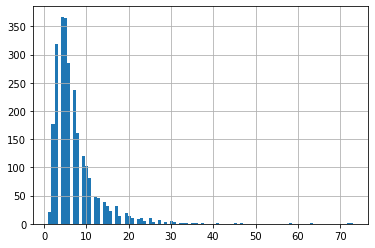

In [20]:
df['how_long_it_took_to_order'].hist(bins=100)

In [21]:
df['place_category'].unique()

array(['American', 'Pizza', 'Burger', 'Juice Bar', 'Japanese', 'Indian',
       'Sushi', 'Bakery', nan, 'Mexican', 'BBQ', 'Dessert', 'Vegan',
       'Fast Food', 'Korean', 'Drug Store', 'Italian', 'Grocery Store',
       'Breakfast', 'Coffee', 'Salad', 'Middle Eastern', 'Mediterranean',
       'Seafood', 'Russian', 'Southern', 'Vegetarian', 'Deli',
       'South American', 'French', 'Chinese', 'Asian', 'Donut',
       'Gluten-Free', 'Office Supplies Store', 'Convenience Store',
       'Shop', 'Food Truck', 'Clothing', 'German', 'Promo',
       'Electronics Store', 'Steak', 'Ice Cream', 'Thai', 'Spanish',
       'Caribbean', 'Vietnamese', 'Book Store', 'Specialty Store',
       'Eastern European', 'Kids & Baby', 'Department Store',
       'Beauty Supply', 'African', 'Restaurant', 'Art Store',
       'Pet Supplies Store'], dtype=object)

In [22]:
#caste the how long it took to order as timedelta in minutes
df['how_long_it_took_to_order'] = df['how_long_it_took_to_order']
df.groupby(by = 'place_category')['how_long_it_took_to_order'].describe().sort_values(by='count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
place_category,,,,,,,,
Italian,382.0,6.772251,4.663812,1.0,4.00,6.0,8.00,29.0
Japanese,315.0,7.336508,5.826124,2.0,4.00,6.0,9.00,45.0
Chinese,235.0,6.314894,5.815062,1.0,4.00,5.0,7.00,72.0
American,194.0,8.025773,5.549995,1.0,5.00,6.0,10.00,31.0
Sushi,189.0,8.645503,4.854943,2.0,5.00,7.0,11.00,27.0
Salad,125.0,7.488000,7.413606,1.0,4.00,6.0,9.00,73.0
Burger,90.0,6.277778,3.932086,1.0,4.00,5.0,7.00,21.0
Indian,67.0,5.865672,4.667410,1.0,3.00,5.0,7.00,29.0
Pizza,64.0,7.781250,8.373179,1.0,4.00,5.5,9.00,63.0


In [23]:
avg_time_to_order = df['how_long_it_took_to_order'].mean()
avg_time_to_order

7.2024040325707634

It appears there isn't meaningful deviation between the most popular restaurants. Few restaurants with smaller counts have greater deviation. I feel that it is safe to use an average value of ~7.2 minutes to fill the remaining N/As.

In [24]:
df['place_category'].fillna('Not Disclosed', inplace=True)
df['item_name'].fillna('Not Disclosed', inplace=True)
df['item_quantity'].fillna('Not Disclosed', inplace=True)
df['item_category_name'].fillna('Not Disclosed', inplace=True)
df['how_long_it_took_to_order'].fillna(avg_time_to_order, inplace=True)


In [25]:
df.isnull().sum()/len(df)


delivery_id                            0.000000
customer_id                            0.000000
jumpman_id                             0.000000
vehicle_type                           0.000000
pickup_place                           0.000000
place_category                         0.000000
item_name                              0.000000
item_quantity                          0.000000
item_category_name                     0.000000
how_long_it_took_to_order              0.000000
pickup_lat                             0.000000
pickup_lon                             0.000000
dropoff_lat                            0.000000
dropoff_lon                            0.000000
when_the_delivery_started              0.000000
when_the_Jumpman_arrived_at_pickup     0.094937
when_the_Jumpman_left_pickup           0.094937
when_the_Jumpman_arrived_at_dropoff    0.000000
dtype: float64

In [26]:
#Less than 10% of the Jumpman Arrived at Pickup & left Pickup are empty, therefore, I'm comfortable dropping the entries with missing data
df = df.dropna(subset=['when_the_Jumpman_arrived_at_pickup','when_the_Jumpman_left_pickup'])

In [27]:
df.isnull().sum()

delivery_id                            0
customer_id                            0
jumpman_id                             0
vehicle_type                           0
pickup_place                           0
place_category                         0
item_name                              0
item_quantity                          0
item_category_name                     0
how_long_it_took_to_order              0
pickup_lat                             0
pickup_lon                             0
dropoff_lat                            0
dropoff_lon                            0
when_the_delivery_started              0
when_the_Jumpman_arrived_at_pickup     0
when_the_Jumpman_left_pickup           0
when_the_Jumpman_arrived_at_dropoff    0
dtype: int64

# Feature Engineering

Calculate the distance between the pickup and dropoff locations using Haversine distance. The Haversine distance is the angular distance between two points on the surface of a sphere. It is important to note this is distance is "as the crow flies", not distances on a map. 

In [28]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

df['haversine_distance_km'] = haversine_distance(df['pickup_lat'],
                                              df['pickup_lon'],
                                              df['dropoff_lat'],
                                              df['dropoff_lon'])

I'm interested in comparing the delivery rates by vehicle.

In [29]:
#separate dataframe
df_sub = df.copy()
df_sub = df_sub.dropna(subset=['when_the_Jumpman_arrived_at_dropoff','when_the_Jumpman_left_pickup'])

select_cols = ['delivery_id','vehicle_type','when_the_Jumpman_left_pickup',
               'when_the_Jumpman_arrived_at_dropoff','haversine_distance_km']
df_sub = df_sub[select_cols]


#calculate travel time in seconds
travel_time_seconds = (df_sub['when_the_Jumpman_arrived_at_dropoff'] - df_sub['when_the_Jumpman_left_pickup']).astype('timedelta64[s]')
df_sub['travel_time_seconds'] = travel_time_seconds

#calculate travel rate in km/s
travel_rate_kms = df_sub['haversine_distance_km'] / df_sub['travel_time_seconds']
df_sub['travel_rate_kms'] = travel_rate_kms

#create avg rate dictionary that I can call later on
avg_rate_dic = {}
unique_vehicles = df_sub['vehicle_type'].unique()

for i in unique_vehicles:
    avg_rate_dic[i] = df_sub[df_sub.vehicle_type==i]['travel_rate_kms'].mean()

In [30]:
#add average vehicle rate to the dataframe
avg_vehicle_rate = []
for value in df['vehicle_type']:
    if value == 'van':
        avg_vehicle_rate.append(avg_rate_dic['van'])
    elif value == 'bicycle':
        avg_vehicle_rate.append(avg_rate_dic['bicycle'])
    elif value == 'car':
        avg_vehicle_rate.append(avg_rate_dic['car'])
    elif value == 'walker':
        avg_vehicle_rate.append(avg_rate_dic['walker'])
    elif value == 'truck':
        avg_vehicle_rate.append(avg_rate_dic['truck'])
    elif value == 'scooter':
        avg_vehicle_rate.append(avg_rate_dic['scooter'])
    elif value == 'motorcycle':
        avg_vehicle_rate.append(avg_rate_dic['motorcycle'])
    else:
        avg_vehicle_rate.append('N/A')
df['avg_vehicle_rate_kms'] = avg_vehicle_rate

In [70]:
df.iloc[0]

delivery_id                                               1377056
customer_id                                                 64452
jumpman_id                                                 104533
vehicle_type                                              bicycle
pickup_place                                  Prince Street Pizza
place_category                                              Pizza
item_name                                   Neapolitan Rice Balls
item_quantity                                                   3
item_category_name                                     Munchables
how_long_it_took_to_order                                      25
pickup_lat                                                40.7231
pickup_lon                                               -73.9946
dropoff_lat                                               40.7197
dropoff_lon                                              -73.9919
when_the_delivery_started              2014-10-16 21:58:58.654910
when_the_J

In [69]:
df.iloc[0]['when_the_Jumpman_left_pickup']

Timestamp('2014-10-16 22:48:23.091253')

In [71]:
df.iloc[0]['when_the_Jumpman_arrived_at_pickup']

Timestamp('2014-10-16 22:26:02.120931')

In [83]:
df.iloc[0]['when_the_Jumpman_left_pickup'] - df.iloc[0]['when_the_Jumpman_arrived_at_pickup']

Timedelta('0 days 00:22:20.970322')

In [82]:
df.iloc[0]['when_the_Jumpman_left_pickup'] - df.iloc[0]['when_the_Jumpman_arrived_at_pickup'] - df.iloc[0]['how_long_it_took_to_order'].astype('timedelta64[m]')

Timedelta('-1 days +23:57:20.970322')

In [85]:
#difference between leaving pickup and arriving at pickup and how long it took to order
diff1 = df['when_the_Jumpman_left_pickup'] - df['when_the_Jumpman_arrived_at_pickup'] - df['how_long_it_took_to_order'].astype('timedelta64[m]')

#simply the amount of time the jumpman waited at the restaurant
diff2 = df['when_the_Jumpman_left_pickup'] - df['when_the_Jumpman_arrived_at_pickup']

In [94]:
#seems odd that 370 have a negative value

print(len(diff1))
print(diff1[diff1.astype('timedelta64[m]')<0])

4719
1      -1 days +23:57:20.970322
8      -1 days +23:58:49.768211
10     -1 days +23:57:35.599710
45     -1 days +23:54:20.805456
64     -1 days +23:54:18.790127
                 ...           
5924   -1 days +23:58:37.487807
5925   -1 days +23:53:50.027812
5960   -1 days +23:59:19.889030
5961   -1 days +23:58:50.123971
5974   -1 days +23:57:25.519233
Length: 371, dtype: timedelta64[ns]


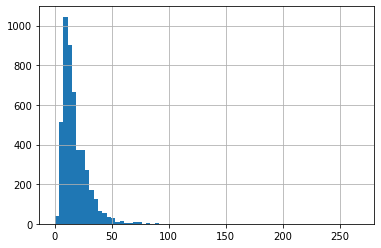

In [101]:
diff2.astype('timedelta64[m]').hist(bins=70)

In [103]:
diff2.astype('timedelta64[m]').mean()

17.73235855054037

# Exploratory Data Analysis (EDA)

## Descriptive Statistics

In [31]:
#what timeframe of data?

print(df.when_the_Jumpman_arrived_at_dropoff.min())
print(df.when_the_Jumpman_arrived_at_dropoff.max())

2014-10-01 01:04:14.355157
2014-10-30 23:29:44.866438


In [32]:
#what is the most popular method of delivery?
df['vehicle_type'].value_counts()

bicycle       3373
car            967
walker         209
van             60
scooter         58
truck           34
motorcycle      18
Name: vehicle_type, dtype: int64

Text(0, 0.5, 'Y')

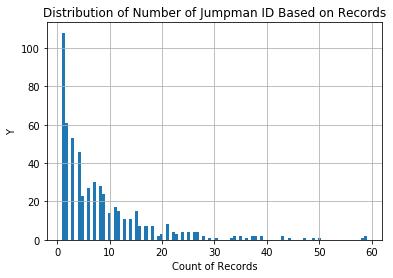

In [33]:
#distribution of jumpman delivery people
df.jumpman_id.value_counts().hist(bins=100)
plt.title('Distribution of Number of Jumpman ID Based on Records')
plt.xlabel('Count of Records')
plt.ylabel('Y')


In [34]:
df.jumpman_id.value_counts().sort_values(ascending=False)

104533    59
99219     59
142394    58
30743     50
3296      49
          ..
177125     1
64628      1
94614      1
137979     1
159647     1
Name: jumpman_id, Length: 565, dtype: int64

In [35]:
top_3 = ['99219','104533','142394']
df[df.jumpman_id.isin(top_3)]

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff,haversine_distance_km,avg_vehicle_rate_kms
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3,Munchables,25.000000,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.654910,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873,0.44,0.002127
21,1356218,128224,99219,bicycle,Osteria Morini,Italian,Garganelli,1,Pasta,7.202404,40.721953,-73.997737,40.716720,-74.012300,2014-10-13 18:00:38.265026,2014-10-13 18:01:53.350477,2014-10-13 18:30:02.582698,2014-10-13 18:40:48.499622,1.36,0.002127
24,1488027,396432,99219,bicycle,Juice Press,Juice Bar,Rehab Shot,2,Other Beverages,7.202404,40.725948,-74.001106,40.718659,-74.002854,2014-10-30 17:36:13.679620,2014-10-30 17:36:59.326686,2014-10-30 17:55:48.869001,2014-10-30 18:05:27.272486,0.82,0.002127
32,1467996,301380,142394,bicycle,ilili Restaurant,Middle Eastern,Hommus,1,Dips,5.000000,40.744188,-73.987531,40.734994,-73.987709,2014-10-27 13:18:37.395003,2014-10-27 13:30:46.385334,2014-10-27 13:46:07.104381,2014-10-27 13:57:18.114768,1.02,0.002127
53,1407558,41130,99219,bicycle,Village Yogurt,Not Disclosed,Not Disclosed,Not Disclosed,Not Disclosed,7.202404,40.737888,-73.996460,40.722746,-73.998857,2014-10-20 11:34:27.673232,2014-10-20 11:35:39.406833,2014-10-20 11:45:29.157896,2014-10-20 11:55:03.887998,1.70,0.002127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5453,1412950,374826,104533,bicycle,Waverly Diner,American,Linzer Tart,1,Desserts,7.202404,40.733012,-74.000056,40.723061,-74.008280,2014-10-21 01:32:28.490579,2014-10-21 01:35:43.948815,2014-10-21 01:47:18.834652,2014-10-21 02:17:23.383088,1.31,0.002127
5473,1272439,354016,99219,bicycle,Waverly Diner,American,Cappuccino,1,Gourmet Coffee,4.000000,40.733012,-74.000056,40.723329,-73.991502,2014-10-01 10:54:28.015258,2014-10-01 11:08:57.885556,2014-10-01 11:15:17.553251,2014-10-01 11:24:58.870870,1.30,0.002127
5544,1489657,390459,104533,bicycle,Shake Shack,Burger,Bottled Water,1,Drinks,7.202404,40.758457,-73.989140,40.750712,-74.002371,2014-10-30 20:21:01.542454,2014-10-30 20:29:06.666940,2014-10-30 21:05:59.314556,2014-10-30 21:18:13.905804,1.41,0.002127
5548,1341499,67370,104533,bicycle,Duane Reade,Drug Store,Not Disclosed,Not Disclosed,Not Disclosed,7.202404,40.733407,-73.986724,40.727516,-73.984562,2014-10-11 20:28:59.236913,2014-10-11 20:43:07.273090,2014-10-11 20:51:59.962551,2014-10-11 20:58:41.812364,0.68,0.002127


In [36]:

from matplotlib import pyplot

In [37]:
df['when_the_delivery_started'].dt.strftime('%m/%d/%Y')


1       10/16/2014
2       10/28/2014
3       10/30/2014
4       10/10/2014
5       10/22/2014
           ...    
5976    10/05/2014
5977    10/05/2014
5979    10/12/2014
5980    10/01/2014
5981    10/27/2014
Name: when_the_delivery_started, Length: 4719, dtype: object

What is the most popular hour for a delivery to start?

In [38]:
delivery_start_hour = []
my_lst = df.index.to_list()

for i in my_lst:
    delivery_start_hour.append(df['when_the_delivery_started'].loc[i].hour)

df['delivery_start_hour'] = delivery_start_hour

Text(0, 0.5, 'Count')

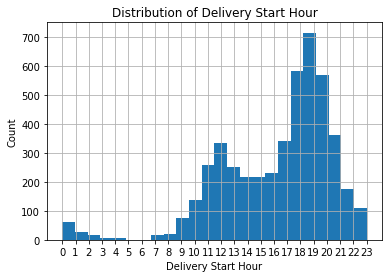

In [39]:
df['delivery_start_hour'].hist(bins = 24, align='mid')
plt.title('Distribution of Delivery Start Hour')
plt.xlabel('Delivery Start Hour')
plt.xticks(np.arange(0, 24, 1))
plt.ylabel('Count')

In [40]:
delivery_start_day = []
my_lst = df.index.to_list()

for i in my_lst:
    delivery_start_day.append(df['when_the_delivery_started'].loc[i].day)

df['delivery_start_day'] = delivery_start_day

Text(0, 0.5, 'Count')

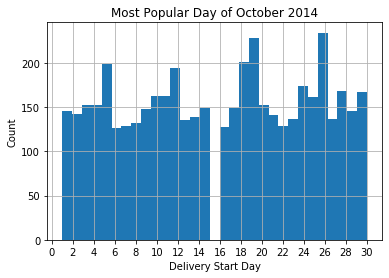

In [41]:
df['delivery_start_day'].hist(bins = 31)
plt.title('Most Popular Day of October 2014')
plt.xlabel('Delivery Start Day')
plt.xticks(np.arange(0, 31, 2))
plt.ylabel('Count')

In [42]:
delivery_start_weekday = []
my_lst = df.index.to_list()

for i in my_lst:
    delivery_start_weekday.append(df['when_the_delivery_started'].loc[i].weekday())

df['delivery_start_weekday'] = delivery_start_weekday

Text(0, 0.5, 'Count')

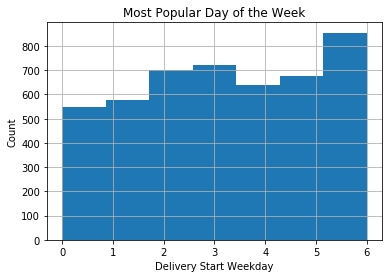

In [43]:
df['delivery_start_weekday'].hist(bins = 7, align='mid')
plt.title('Most Popular Day of the Week')
plt.xlabel('Delivery Start Weekday')
plt.xticks(np.arange(0, 7, 1))
plt.ylabel('Count')

Text(0, 0.5, 'Count')

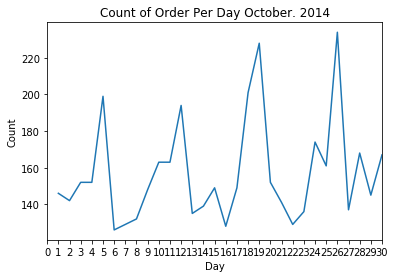

In [44]:
df['delivery_start_day'].value_counts().sort_index().plot()
plt.title('Count of Order Per Day October. 2014')
plt.xlabel('Day')
plt.xticks(np.arange(0, 31, 1))
plt.ylabel('Count')

In [45]:
print(df['delivery_start_day'].value_counts().sort_index()[3:10].sum())
print(df['delivery_start_day'].value_counts().sort_index()[11:17].sum())
print(df['delivery_start_day'].value_counts().sort_index()[18:24].sum())
print(df['delivery_start_day'].value_counts().sort_index()[25:31].sum())

1049
894
960
851


In [46]:
df['delivery_start_day'].value_counts().sort_index()

1     146
2     142
3     152
4     152
5     199
6     126
7     129
8     132
9     148
10    163
11    163
12    194
13    135
14    139
15    149
16    128
17    149
18    201
19    228
20    152
21    141
22    129
23    136
24    174
25    161
26    234
27    137
28    168
29    145
30    167
Name: delivery_start_day, dtype: int64

In [47]:
#Count of order per week
week_1_count = df['delivery_start_day'].value_counts().sort_index()[:7].sum()
week_2_count = df['delivery_start_day'].value_counts().sort_index()[7:14].sum()
week_3_count = df['delivery_start_day'].value_counts().sort_index()[14:21].sum()
week_4_count = df['delivery_start_day'].value_counts().sort_index()[21:28].sum()
week_5_count = df['delivery_start_day'].value_counts().sort_index()[28:31].sum()

print(week_1_count)
print(week_2_count)
print(week_3_count)
print(week_4_count)
print(week_5_count)

1046
1074
1148
1139
312


Most popular dropoff zip codes

In [48]:
df.iloc[0]

delivery_id                                               1377056
customer_id                                                 64452
jumpman_id                                                 104533
vehicle_type                                              bicycle
pickup_place                                  Prince Street Pizza
place_category                                              Pizza
item_name                                   Neapolitan Rice Balls
item_quantity                                                   3
item_category_name                                     Munchables
how_long_it_took_to_order                                      25
pickup_lat                                                40.7231
pickup_lon                                               -73.9946
dropoff_lat                                               40.7197
dropoff_lon                                              -73.9919
when_the_delivery_started              2014-10-16 21:58:58.654910
when_the_J

Who are the jumpmen?

In [49]:
df['jumpman_id'].value_counts()

104533    59
99219     59
142394    58
30743     50
3296      49
          ..
122573     1
155385     1
14610      1
125160     1
159647     1
Name: jumpman_id, Length: 565, dtype: int64

In [50]:
value_counts = df['jumpman_id'].value_counts()
value_counts[value_counts==1]

179183    1
170959    1
153533    1
167758    1
161713    1
         ..
122573    1
155385    1
14610     1
125160    1
159647    1
Name: jumpman_id, Length: 108, dtype: int64

In [51]:
value_counts[value_counts>5]

104533    59
99219     59
142394    58
30743     50
3296      49
          ..
143807     6
110192     6
20124      6
156008     6
175555     6
Name: jumpman_id, Length: 274, dtype: int64

In [52]:
df['jumpman_id'].value_counts().sum()

4719

Text(0, 0.5, 'Count')

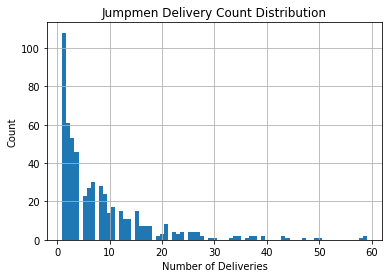

In [53]:
df['jumpman_id'].value_counts().hist(bins=75)
plt.title('Jumpmen Delivery Count Distribution')
plt.xlabel('Number of Deliveries')
plt.ylabel('Count')

In [54]:
df['jumpman_id'].value_counts().mean()

8.352212389380531

In [55]:
df['jumpman_id'].value_counts().max()

59

In [56]:
df['jumpman_id'].nunique()

565

In [57]:
unique_jumpmen = df['jumpman_id'].unique()

df[df.jumpman_id.isin(unique_jumpmen)]['vehicle_type'].value_counts()

bicycle       3373
car            967
walker         209
van             60
scooter         58
truck           34
motorcycle      18
Name: vehicle_type, dtype: int64

I want to add several demographic statistics to the dataset. To do this, I will need to use the uszipcode package. I can find the correct zipcode using latitude and longitude coordinates. I will then be able to add estimated population and median household income population.

In [58]:
from uszipcode import SearchEngine

In [59]:
search = SearchEngine(simple_zipcode=True) # set simple_zipcode=False to use rich info database

I want to add the pickup and dropoff location zipcodes to the dataset. 

In [60]:
f = lambda x, y : search.by_coordinates(lat=x, lng=y, returns=1)[0].to_dict()['zipcode']
df['pickup_zipcode'] = df[['pickup_lat','pickup_lon']].apply(lambda x : f(*x), axis=1)
df['dropoff_zipcode'] = df[['dropoff_lat','dropoff_lon']].apply(lambda x : f(*x), axis=1)

In [61]:
f = lambda x, y : search.by_coordinates(lat=x, lng=y, returns=1)[0].to_dict()['population']
df['pickup_population'] = df[['pickup_lat','pickup_lon']].apply(lambda x : f(*x), axis=1)
df['dropoff_population'] = df[['dropoff_lat','dropoff_lon']].apply(lambda x : f(*x), axis=1)

In [62]:
f = lambda x, y : search.by_coordinates(lat=x, lng=y, returns=1)[0].to_dict()['median_household_income']
df['pickup_med_hh_income'] = df[['pickup_lat','pickup_lon']].apply(lambda x : f(*x), axis=1)
df['dropoff_med_hh_income'] = df[['dropoff_lat','dropoff_lon']].apply(lambda x : f(*x), axis=1)


In [63]:
df.sort_values(by='dropoff_med_hh_income', ascending =False)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,...,avg_vehicle_rate_kms,delivery_start_hour,delivery_start_day,delivery_start_weekday,pickup_zipcode,dropoff_zipcode,pickup_population,dropoff_population,pickup_med_hh_income,dropoff_med_hh_income
3185,1274928,93113,99219,bicycle,The Odeon,American,Sauteed Spinach,1,Sides (dinner),9.000000,...,0.002127,19,1,2,10007,10282,6988,4783,216037.0,230952.0
3334,1295488,128600,114469,bicycle,Tamarind TriBeCa,Indian,Tamarind Rice,1,Basmati Degh Rice,2.000000,...,0.002127,19,4,5,10013,10282,27700,4783,83725.0,230952.0
46,1379189,47440,112646,bicycle,Bareburger,Burger,Barest Burger,1,Bareburgers,6.000000,...,0.002127,11,17,4,10012,10282,24090,4783,86594.0,230952.0
1344,1488122,47440,123581,bicycle,Bareburger,Burger,Barest Burger,1,Bareburgers,8.000000,...,0.002127,17,30,3,10012,10282,24090,4783,86594.0,230952.0
3499,1288301,268958,60149,car,Parm,Italian,Choose 3 Vegetables,1,Vegetables,5.000000,...,0.002448,19,3,4,10012,10282,24090,4783,86594.0,230952.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5873,1393083,58675,140096,bicycle,Shake Shack,Burger,Fries,2,Fries,7.202404,...,0.002127,21,18,5,10282,10271,4783,0,230952.0,NaN
5910,1314103,87747,153766,bicycle,Blue Ribbon Fried Chicken,American,Drumstick,2,By the Piece,7.202404,...,0.002127,16,7,1,10002,10199,81410,9,33218.0,NaN
5913,1368358,95049,61900,bicycle,Nobu Next Door,Sushi,Rock Shrimp Tempura,1,Dinner Hot Dishes,12.000000,...,0.002127,18,15,2,10013,10199,27700,9,83725.0,NaN
5945,1348292,123479,155879,car,Boqueria,Spanish,Aged Mahon (Menorca),1,Quesos,9.000000,...,0.002448,18,12,6,10011,10171,50984,0,104238.0,NaN


<a id='scratch'></a>
## Scratch

rate = df.iloc[0]['avg_vehicle_rate_kms']
distance = df.iloc[0]['haversine_distance_km']
time = distance/rate
time = time.astype('timedelta64[s]')
time

print(df.iloc[0]['when_the_Jumpman_arrived_at_dropoff'])
print(df.iloc[0]['when_the_Jumpman_arrived_at_dropoff'] - time)

df['time_pickup_to_dropoff'] = df['haversine_distance_km']/df['avg_vehicle_rate_kms']
df['time_pickup_to_dropoff'] = df['time_pickup_to_dropoff'].astype('timedelta64[s]')

for i in df[df['when_the_Jumpman_left_pickup'].isna()].index:
    #rate = df.iloc[i]['avg_vehicle_rate_kms']
    #distance = df.iloc[i]['haversine_distance_km']
    #time = (distance/rate).astype('timedelta64[s]')
    #df.iloc[i]['when_the_Jumpman_left_pickup'] = (df.iloc[i]['when_the_Jumpman_arrived_at_dropoff'] - (df.iloc[0]['haversine_distance_km']/df.iloc[i]['avg_vehicle_rate_kms']).astype('timedelta64[s]'))
    print(df.iloc[i]['when_the_Jumpman_arrived_at_dropoff'] - df.iloc[i])
    
    
    
    
null_pickup = df[df['when_the_Jumpman_left_pickup'].isnull()].index.to_list()

for i in null_pickup:
    df.loc[i]['when_the_Jumpman_left_pickup'] = df.loc[i]['when_the_Jumpman_arrived_at_dropoff'] - df.loc[i]['time_pickup_to_dropoff']

#df.iloc[0]['how_long_it_took_to_order'].minutes

time_cols = ['how_long_it_took_to_order']
for i in time_cols:
    df[i] = pd.to_datetime(df[i])
    
    
def minutes(data_input):
    return data_input.minute*60.0 + data_input.second

minute = df.how_long_it_took_to_order.apply(minutes)
df['min_to_order'] = round(minute/60,2)

df['how_long_it_took_to_order'] = pd.to_datetime(df.how_long_it_took_to_order, format = '%H:%M:%S.%f')

df['min_to_order'].hist(bins=50)
df['min_to_order'].describe()
sns.boxplot(y="min_to_order", data=df, orient='h')
sns.violinplot(x="vehicle_type", y="min_to_order", data=df, split=False, inner="quart", linewidth=1.3)

def get_population (zip_code):
    '''Get demographic information by zipcode'''
    zipcode = search.by_zipcode(zip_code)
    some_zip = zipcode.to_dict()
    population = some_zip['population']
    return population

def get_med_income (zip_code):
    '''Get demographic information by zipcode'''
    income = search.by_zipcode(zip_code)
    some_zip = zipcode.to_dict()
    income = some_zip['median_household_income']
    return income
    
get_population(10022)

#sample zipcode

search = SearchEngine(simple_zipcode=True) # set simple_zipcode=False to use rich info database
zipcode = search.by_zipcode("10022")
zip_10022 = zipcode.to_dict()
zip_10022
zip_10022['median_household_income']